# Clustering in the Embedding Space

This notebook clusters **node embeddings** extracted from **GraphSAGE model**

We **load a checkpoint** and run a single forward pass to get node embeddings `Z`, then we run clustering (KMeans / MeanShift) and interpret clusters.

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path

from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv, to_hetero

# Import this project modules
REPO_ROOT = Path('.').resolve()
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from dataset import WikiRfAPreprocessor
from gnn_embedding_model import HeteroPolarityGNN

# Device
DEVICE = torch.device(
    "cuda" if torch.cuda.is_available() else
    ("mps" if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available() else "cpu")
)
print("DEVICE:", DEVICE)


DEVICE: mps


In [ ]:
DATA_PATH = Path("dataset/wiki-RfA.txt.gz")

# Checkpoint
CHECKPOINT_PATH = Path("checkpoints/votegnn_best.pt")

SEED = 42
K_RANGE = range(2, 21) # candidates for KMeans k


## 1) Load and preprocess Wiki-RfA

We parse the SNAP `wiki-RfA.txt.gz` file and build:
- `edge_index`: `[2, E]` tensor of (src_id -> tgt_id)
- `vot`: vote label in `{-1, 0, +1}` (oppose, neutral, support)
- `dates`: `YYYYMMDD` (int) for optional temporal analyses


In [24]:
# 1) Load raw samples
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"

pre = WikiRfAPreprocessor(DATA_PATH)
pre.load()

print("Loaded samples:", len(pre.samples))
print("Example sample:", pre.samples[0])  # (SRC, TGT, VOT, DAT)

# Build DataFrame for easier aggregation
df = pd.DataFrame(pre.samples, columns=["src_user", "tgt_user", "vot", "dat"])
df["dat"] = df["dat"].astype(int)
df["vot"] = df["vot"].astype(int)

df.head()

# 2) Encode users -> contiguous node ids [0..N-1]
users = sorted(set(df["src_user"]).union(set(df["tgt_user"])))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)

user_to_id = dict(zip(users, user_ids))
id_to_user = dict(zip(user_ids, users))

df["src"] = df["src_user"].map(user_to_id).astype(int)
df["tgt"] = df["tgt_user"].map(user_to_id).astype(int)

num_nodes = len(users)
num_edges = len(df)

print("num_nodes =", num_nodes, "min_id =", min(user_ids), "max_id =", max(user_ids))
print(f"num_edges={num_edges:,}")
df[["src","tgt","vot","dat"]].head()

Loading dataset from dataset/wiki-RfA.txt.gz...

------- Dataset Loaded -------
Total valid samples loaded: 188816
Example sample (SRC, TGT, VOT, DATE): ('Steel1943', 'BDD', 1, 20130419)

Discarded edges breakdown:
  EMPTY_ERROR: 9367
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Legoktm', '')
    Skipped edge: ('Majoreditor', 'Lord Roem', '')
  SELF_LOOP: 88
    Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
    Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
    Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
    Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
  ERROR_OTHERS: 4
    Skipped edge: ('JonasEncyclopedia', 'Zagalejo', '14:47, 1 Julu 2012')
    Skipped edge: ('HJ Mitchell', 'Alan16', '20:44, 3 Janry 2010')
    Skipped edge: ('Pathoschild', 'Werdna', '31:29, 24 May 2008')
    Skipped edge: ('QuasyBoy', 'Imdanumber1', '17:44, 26 Mya 2007')
L

,src,tgt,vot,dat
0,9061,950,1,20130419
1,2177,950,1,20130420
2,4377,950,1,20130419
3,1976,950,1,20130420
4,6389,950,1,20130420


In [25]:
X = torch.tensor(df[["src","tgt"]].values, dtype=torch.long)
dates = df["dat"].values.astype(int)

# Message-passing graph 
edge_index = X.t().contiguous()  # [2, E_train_pos]

# Filling features
x_features = torch.zeros((len(users), 0), dtype=torch.float)

data = HeteroData()
data['user'].x = x_features
data['user', 'votes', 'user'].edge_index = edge_index
data['user', 'rev_votes', 'user'].edge_index = edge_index.flip(0)
data = data.to(DEVICE)
metadata = data.metadata()



# LOAD CHECKPOINT

In [26]:
if not CHECKPOINT_PATH.exists():
    raise FileNotFoundError(
        f"Checkpoint not found: {CHECKPOINT_PATH}\n"
        "→ Save it from the training notebook by passing checkpoint_path=... to train_hierarchical()."
    )

def load_checkpoint(path: Path, map_location=DEVICE):
    """Load a checkpoint saved either as:
    - a full dict with key 'model_state' or 'state_dict'
    - or directly a state_dict
    Returns: (meta_dict, state_dict_loaded)
    """
    ckpt = torch.load(path, map_location=map_location)
    meta = {}
    if isinstance(ckpt, dict) and ("model_state" in ckpt or "state_dict" in ckpt):
        state = ckpt.get("model_state", ckpt.get("state_dict"))
        meta = {k: v for k, v in ckpt.items() if k not in ["model_state", "state_dict", "optimizer_state"]}
    elif isinstance(ckpt, dict):
        # Heuristic: treat dict as a raw state_dict
        state = ckpt
    else:
        raise ValueError(f"Unsupported checkpoint format at {path}")
    return meta, state

meta, state = load_checkpoint(CHECKPOINT_PATH, map_location=DEVICE)
num_users_ckpt, emb_dim = state["node_emb.weight"].shape
hidden_dim = state["hetero_gnn.conv2.user__votes__user.lin_l.weight"].shape[0]

print("Loaded checkpoint:", CHECKPOINT_PATH)
if meta:
    print("Checkpoint metadata:")
    for k, v in meta.items():
        if k in ["epoch", "best_metric"]:
            print(f" - {k}: {v}")

model = HeteroPolarityGNN(
    metadata=metadata,
    num_users=num_nodes,
    emb_dim=emb_dim,
    hidden_dim=hidden_dim,
    dropout=0.2
).to(DEVICE)


model.load_state_dict(state, strict=True)
model.eval()

Loaded checkpoint: checkpoints/votegnn_best.pt
Checkpoint metadata:
 - epoch: 31
 - best_metric: 0.5138985346341309


HeteroPolarityGNN(
  (node_emb): Embedding(11128, 64)
  (hetero_gnn): GraphModule(
    (dropout): ModuleDict(
      (user): Dropout(p=0.2, inplace=False)
    )
    (conv1): ModuleDict(
      (user__votes__user): SAGEConv(64, 128, aggr=mean)
      (user__rev_votes__user): SAGEConv(64, 128, aggr=mean)
    )
    (conv2): ModuleDict(
      (user__votes__user): SAGEConv(128, 128, aggr=mean)
      (user__rev_votes__user): SAGEConv(128, 128, aggr=mean)
    )
  )
  (pol_mlp): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

In [ ]:
# -------------------------------------------------------------------
# Extract node embeddings Z from the trained encoder
# -------------------------------------------------------------------
with torch.no_grad():
    all_ids = torch.arange(num_nodes, device=DEVICE)
    x_user = model.node_emb(all_ids)  # [N, emb_dim]
    z_dict = model.hetero_gnn({"user": x_user}, data.edge_index_dict)
    Z = z_dict["user"].detach().cpu().numpy()  # [N, hidden_dim]


print("Z shape:", Z.shape) # (num_users, hidden_dim)


Saved embeddings -> None
Z shape: (11128, 128)


In [28]:
# Quick sanity check: embeddings are finite
assert np.isfinite(Z).all(), "Found NaN/Inf in embeddings!"

## 3) Clustering embeddings

We run:
- **KMeans**: we sweep `k` and pick a value using internal metrics (Silhouette / CH / DB).
- **MeanShift**: bandwidth-based clustering (can produce variable number of clusters).

In [29]:
# Normalize embeddings
Z_norm = normalize(Z, norm="l2")

# Quick sanity check
print("Z_norm:", Z_norm.shape, "mean L2:", np.mean(np.linalg.norm(Z_norm, axis=1)))


Z_norm: (11128, 128) mean L2: 1.0


In [30]:
# -------------------------
# KMeans
# -------------------------
K_MIN, K_MAX = 2, 20

Z_s = Z_norm

results = []
for k in range(K_MIN, K_MAX + 1):
    km = KMeans(n_clusters=k, n_init=10, random_state=SEED)
    labels = km.fit_predict(Z_norm)
    sil = silhouette_score(Z_s, labels)
    ch = calinski_harabasz_score(Z_s, labels)
    db = davies_bouldin_score(Z_s, labels)

    results.append((k, sil, ch, db))

res_df = pd.DataFrame(results, columns=["k", "silhouette", "calinski_harabasz", "davies_bouldin"])
res_df.sort_values("silhouette", ascending=False).head(10)


,k,silhouette,calinski_harabasz,davies_bouldin
1,3,0.127871,1140.218307,2.385551
0,2,0.112654,1130.913899,3.023240
2,4,0.095157,974.279286,2.930246
3,5,0.086778,844.308294,2.960350
4,6,0.073660,732.957669,3.054966
6,8,0.073434,590.861768,3.224389
5,7,0.073081,653.161545,3.132060
7,9,0.061139,541.439467,3.243134
8,10,0.057252,501.175001,3.269279
9,11,0.054917,468.939363,3.221401


k_best: 3


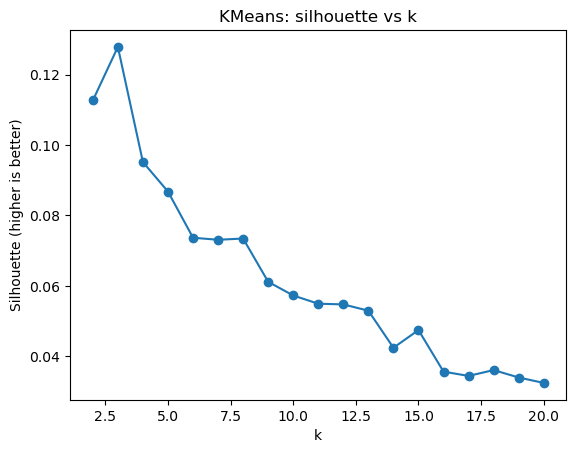

In [31]:
# Choose best k by highest silhouette
k_best = int(res_df.sort_values("silhouette", ascending=False).iloc[0]["k"])
print("k_best:", k_best)

plt.figure()
plt.plot(res_df["k"], res_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette (higher is better)")
plt.title("KMeans: silhouette vs k")
plt.show()


In [32]:
# Fit final KMeans with best k
kmeans = KMeans(n_clusters=k_best, n_init=20, random_state=SEED)
labels_km = kmeans.fit_predict(Z_norm)

print("KMeans clusters:", np.unique(labels_km).size)
pd.Series(labels_km).value_counts().head()


KMeans clusters: 3


1    6988
0    2785
2    1355
Name: count, dtype: int64

In [45]:
# -------------------------
# MeanShift + dimensionality reduction
# -------------------------
PCA_DIMS = 10
pca = PCA(n_components=PCA_DIMS, random_state=SEED)
Z_pca = pca.fit_transform(Z_norm)

idx_ms = np.random.choice(Z_pca.shape[0], Z_pca.shape[0], replace=False)

sub = np.random.choice(Z_pca.shape[0], 10000, replace=False)
bandwidth = estimate_bandwidth(Z_pca[sub], quantile=0.05, n_samples=10000)
print("Estimated bandwidth:", bandwidth)

meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels_ms = meanshift.fit_predict(Z_pca)

print("MeanShift clusters:", np.unique(labels_ms).size)
pd.Series(labels_ms).value_counts().head()


Estimated bandwidth: 0.43791752277535034
MeanShift clusters: 3


0    7298
1    2470
2    1360
Name: count, dtype: int64

## 4) Visualize clusters (t-SNE)


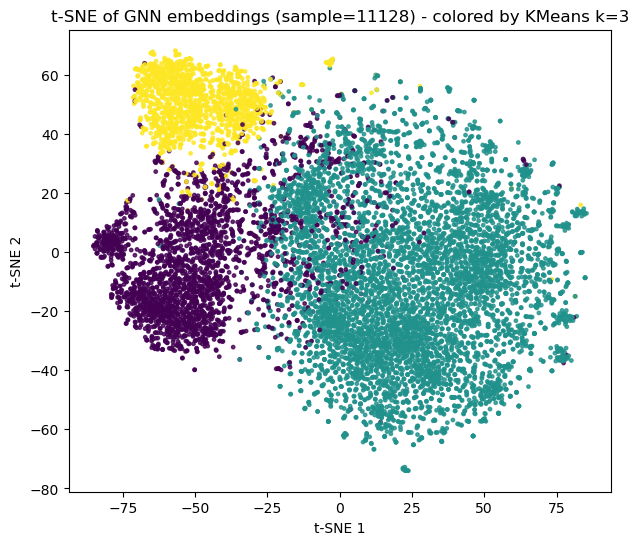

In [34]:
idx_vis = np.random.choice(Z_norm.shape[0], Z_norm.shape[0], replace=False)
Z_vis = Z_norm[idx_vis]
lab_vis = labels_km[idx_vis]

tsne = TSNE(n_components=2, perplexity=30, learning_rate="auto", init="pca", random_state=SEED)
Z_2d = tsne.fit_transform(Z_vis)

plt.figure(figsize=(7, 6))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], s=6, c=lab_vis, alpha=0.8)
plt.title(f"t-SNE of GNN embeddings (sample={len(idx_vis)}) - colored by KMeans k={k_best}")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()


## 5) Cluster interpretation via voting behavior

We compute node-level features from the *raw vote edges* and then aggregate by cluster:

- Activity: out-degree (votes cast), in-degree (votes received)
- Outgoing vote profile: %oppose / %neutral / %support
- Incoming vote profile: %oppose / %neutral / %support


In [35]:
# Build node-level vote profiles
# Outgoing (as voter)
out_deg = df.groupby("src").size().rename("out_deg")
in_deg  = df.groupby("tgt").size().rename("in_deg")

def counts_by_vote(col):
    # returns DataFrame indexed by node_id with columns vote_-1, vote_0, vote_1
    c = (
        df.groupby([col, "vot"])
          .size()
          .unstack(fill_value=0)
          .rename(columns={-1: "oppose", 0: "neutral", 1: "support"})
    )
    # ensure all columns exist
    for cc in ["oppose", "neutral", "support"]:
        if cc not in c.columns:
            c[cc] = 0
    return c[["oppose", "neutral", "support"]]

out_counts = counts_by_vote("src").add_prefix("out_")
in_counts  = counts_by_vote("tgt").add_prefix("in_")

node_stats = pd.DataFrame(index=np.arange(num_nodes))
node_stats = node_stats.join(out_deg).join(in_deg).join(out_counts).join(in_counts)
node_stats = node_stats.fillna(0).astype(int)

# Ratios (avoid division by zero)
node_stats["out_total"] = node_stats["out_oppose"] + node_stats["out_neutral"] + node_stats["out_support"]
node_stats["in_total"]  = node_stats["in_oppose"]  + node_stats["in_neutral"]  + node_stats["in_support"]

for prefix in ["out", "in"]:
    tot = node_stats[f"{prefix}_total"].replace(0, np.nan)
    node_stats[f"{prefix}_oppose_ratio"]  = node_stats[f"{prefix}_oppose"]  / tot
    node_stats[f"{prefix}_neutral_ratio"] = node_stats[f"{prefix}_neutral"] / tot
    node_stats[f"{prefix}_support_ratio"] = node_stats[f"{prefix}_support"] / tot


node_stats.head()


,out_deg,in_deg,out_oppose,out_neutral,out_support,in_oppose,in_neutral,in_support,out_total,in_total,out_oppose_ratio,out_neutral_ratio,out_support_ratio,in_oppose_ratio,in_neutral_ratio,in_support_ratio
0,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN
1,13,0,0,0,13,0,0,0,13,0,0.0,0.0,1.0,NaN,NaN,NaN
2,3,0,0,0,3,0,0,0,3,0,0.0,0.0,1.0,NaN,NaN,NaN
3,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN
4,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN


In [36]:
# Attach cluster labels + usernames
nodes_df = pd.DataFrame({
    "node_id": np.arange(num_nodes),
    "username": [id_to_user[i] for i in range(num_nodes)],
    "cluster_kmeans": labels_km,
    "cluster_meanshift": labels_ms,
})
nodes_df = nodes_df.join(node_stats, on="node_id")

nodes_df.head()


,node_id,username,cluster_kmeans,cluster_meanshift,out_deg,in_deg,out_oppose,out_neutral,out_support,in_oppose,in_neutral,in_support,out_total,in_total,out_oppose_ratio,out_neutral_ratio,out_support_ratio,in_oppose_ratio,in_neutral_ratio,in_support_ratio
0,0,!---slappdash---!,1,0,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN
1,1,%D0%90,0,0,13,0,0,0,13,0,0,0,13,0,0.0,0.0,1.0,NaN,NaN,NaN
2,2,'sed,1,0,3,0,0,0,3,0,0,0,3,0,0.0,0.0,1.0,NaN,NaN,NaN
3,3,(.Y.),1,0,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN
4,4,(:Julien:),1,0,1,0,0,0,1,0,0,0,1,0,0.0,0.0,1.0,NaN,NaN,NaN


In [ ]:
# Aggregate by KMeans cluster
cluster_col = "cluster_kmeans"

cluster_summary = (
    nodes_df.groupby(cluster_col)
    .agg(
        size=("node_id", "count"),
        share=("node_id", lambda s: len(s)/len(nodes_df)),

        # zero-rate
        in_total_zero_rate=("in_total", lambda s: (s == 0).mean()),
        out_total_zero_rate=("out_total", lambda s: (s == 0).mean()),
        in_total_pos_rate=("in_total", lambda s: (s > 0).mean()),
        out_total_pos_rate=("out_total", lambda s: (s > 0).mean()),

        # degree stats
        out_deg_mean=("out_deg", "mean"),
        out_deg_median=("out_deg", "median"),
        in_deg_mean=("in_deg", "mean"),
        in_deg_median=("in_deg", "median"),

        # --- MEAN ratios ---
        out_support_ratio_mean=("out_support_ratio", "mean"),
        out_oppose_ratio_mean=("out_oppose_ratio", "mean"),
        out_neutral_ratio_mean=("out_neutral_ratio", "mean"),
        in_support_ratio_mean=("in_support_ratio", "mean"),
        in_oppose_ratio_mean=("in_oppose_ratio", "mean"),
        in_neutral_ratio_mean=("in_neutral_ratio", "mean"),

        # --- COND mean ratios (total>0) ---
        out_support_ratio_mean_cond=("out_support_ratio", lambda s: s.dropna().mean()),
        out_oppose_ratio_mean_cond=("out_oppose_ratio", lambda s: s.dropna().mean()),
        out_neutral_ratio_mean_cond=("out_neutral_ratio", lambda s: s.dropna().mean()),
        in_support_ratio_mean_cond=("in_support_ratio", lambda s: s.dropna().mean()),
        in_oppose_ratio_mean_cond=("in_oppose_ratio", lambda s: s.dropna().mean()),
        in_neutral_ratio_mean_cond=("in_neutral_ratio", lambda s: s.dropna().mean()),

        # --- SUM counts ---
        out_support_sum=("out_support", "sum"),
        out_oppose_sum=("out_oppose", "sum"),
        out_neutral_sum=("out_neutral", "sum"),
        out_total_sum=("out_total", "sum"),

        in_support_sum=("in_support", "sum"),
        in_oppose_sum=("in_oppose", "sum"),
        in_neutral_sum=("in_neutral", "sum"),
        in_total_sum=("in_total", "sum"),
    )
    .sort_values("size", ascending=False)
)

# --- WEIGHTED ratios ---
cluster_summary["out_support_ratio_weighted"] = cluster_summary["out_support_sum"] / cluster_summary["out_total_sum"].replace(0, np.nan)
cluster_summary["out_oppose_ratio_weighted"]  = cluster_summary["out_oppose_sum"]  / cluster_summary["out_total_sum"].replace(0, np.nan)
cluster_summary["out_neutral_ratio_weighted"] = cluster_summary["out_neutral_sum"] / cluster_summary["out_total_sum"].replace(0, np.nan)

cluster_summary["in_support_ratio_weighted"] = cluster_summary["in_support_sum"] / cluster_summary["in_total_sum"].replace(0, np.nan)
cluster_summary["in_oppose_ratio_weighted"]  = cluster_summary["in_oppose_sum"]  / cluster_summary["in_total_sum"].replace(0, np.nan)
cluster_summary["in_neutral_ratio_weighted"] = cluster_summary["in_neutral_sum"] / cluster_summary["in_total_sum"].replace(0, np.nan)

compact_cols = [
    "size","share",
    "out_deg_median","in_deg_median",
    "out_total_zero_rate","in_total_zero_rate",
    "out_support_ratio_weighted","out_oppose_ratio_weighted","out_neutral_ratio_weighted",
    "in_support_ratio_weighted","in_oppose_ratio_weighted","in_neutral_ratio_weighted",
]

compact = cluster_summary[compact_cols].copy()
compact["share"] = (compact["share"]*100).round(1)
compact["out_total_zero_rate"] = (compact["out_total_zero_rate"]*100).round(1)
compact["in_total_zero_rate"] = (compact["in_total_zero_rate"]*100).round(1)

for c in compact.columns:
    if "ratio" in c:
        compact[c] = compact[c].round(3)

print("=== Compact cluster table (weighted ratios, % rates) ===")
print(compact.to_string())


=== Compact cluster table (weighted ratios, % rates) ===
                size  share  out_deg_median  in_deg_median  out_total_zero_rate  in_total_zero_rate  out_support_ratio_weighted  out_oppose_ratio_weighted  out_neutral_ratio_weighted  in_support_ratio_weighted  in_oppose_ratio_weighted  in_neutral_ratio_weighted
cluster_kmeans                                                                                                                                                                                                                                                        
1               6988   62.8             2.0            0.0                  0.0                99.7                       0.714                      0.240                       0.045                      0.542                     0.356                      0.101
0               2785   25.0            14.0           44.0                 10.0                24.0                       0.740                      0.193

# Better Cluster Explanation

In [54]:
import numpy as np
import pandas as pd

def _dominant_vote(r_support, r_oppose, r_neutral):
    vals = np.array([r_support, r_oppose, r_neutral], dtype=float)
    labels = np.array(["support", "oppose", "neutral"])
    if np.all(np.isnan(vals)):
        return "unknown"
    return labels[int(np.nanargmax(vals))]

def _role_hint(out_deg_med, in_deg_med, in_zero_rate, out_zero_rate):
    # simple heuristic
    if in_zero_rate > 0.8 and out_zero_rate < 0.2:
        return "mostly voters (rarely receive votes)"
    if out_zero_rate > 0.8 and in_zero_rate < 0.2:
        return "mostly candidates (rarely vote)"
    if in_deg_med > out_deg_med:
        return "candidate-heavy"
    if out_deg_med > in_deg_med:
        return "voter-heavy"
    return "mixed role"

def print_cluster_report(nodes_df, cluster_summary, cluster_col="cluster_kmeans", topn=5):
    for c, r in cluster_summary.iterrows():
        sub = nodes_df[nodes_df[cluster_col] == c].copy()

        role = _role_hint(r["out_deg_median"], r["in_deg_median"],
                          r["in_total_zero_rate"], r["out_total_zero_rate"])

        dom_out_w = _dominant_vote(r["out_support_ratio_weighted"], r["out_oppose_ratio_weighted"], r["out_neutral_ratio_weighted"])
        dom_in_w  = _dominant_vote(r["in_support_ratio_weighted"],  r["in_oppose_ratio_weighted"],  r["in_neutral_ratio_weighted"])

        print(f"CLUSTER {c} | size={int(r['size'])} ({r['share']*100:.1f}%)")
        print(f"Role: {role}")
        print(f"Median out_deg={r['out_deg_median']:.1f} | Median in_deg={r['in_deg_median']:.1f}")
        print(f"% no outgoing votes (out_total=0): {r['out_total_zero_rate']*100:.1f}%")
        print(f"% no incoming votes (in_total=0): {r['in_total_zero_rate']*100:.1f}%")

        print("\nOUT vote mix:")
        print(f"  Weighted dominant: {dom_out_w} | "
              f"support={r['out_support_ratio_weighted']:.3f}, oppose={r['out_oppose_ratio_weighted']:.3f}, neutral={r['out_neutral_ratio_weighted']:.3f}")
        print(f"  Mean (node-avg):         "
              f"support={r['out_support_ratio_mean']:.3f}, oppose={r['out_oppose_ratio_mean']:.3f}, neutral={r['out_neutral_ratio_mean']:.3f}")

        print("\nIN vote mix:")
        print(f"  Weighted dominant: {dom_in_w} | "
              f"support={r['in_support_ratio_weighted']:.3f}, oppose={r['in_oppose_ratio_weighted']:.3f}, neutral={r['in_neutral_ratio_weighted']:.3f}")
        print(f"  Mean (node-avg):         "
              f"support={r['in_support_ratio_mean']:.3f}, oppose={r['in_oppose_ratio_mean']:.3f}, neutral={r['in_neutral_ratio_mean']:.3f}")

        print("\nTop voters by out_deg:")
        cols_v = ["username","out_deg","out_support_ratio","out_oppose_ratio","out_neutral_ratio"]
        print(sub.sort_values("out_deg", ascending=False)[cols_v].head(topn).to_string(index=False))

        print("\nTop candidates by in_deg:")
        cols_c = ["username","in_deg","in_support_ratio","in_oppose_ratio","in_neutral_ratio"]
        print(sub.sort_values("in_deg", ascending=False)[cols_c].head(topn).to_string(index=False))
        print("\n\n")



In [55]:
print_cluster_report(nodes_df, cluster_summary, cluster_col="cluster_kmeans", topn=5)

CLUSTER 1 | size=6988 (62.8%)
Role: mostly voters (rarely receive votes)
Median out_deg=2.0 | Median in_deg=0.0
% no outgoing votes (out_total=0): 0.0%
% no incoming votes (in_total=0): 99.7%

OUT vote mix:
  Weighted dominant: support | support=0.714, oppose=0.240, neutral=0.045
  Mean (node-avg):         support=0.744, oppose=0.221, neutral=0.035

IN vote mix:
  Weighted dominant: support | support=0.542, oppose=0.356, neutral=0.101
  Mean (node-avg):         support=0.453, oppose=0.443, neutral=0.104

Top voters by out_deg:
          username  out_deg  out_support_ratio  out_oppose_ratio  out_neutral_ratio
        PhilKnight      279           0.931900          0.057348           0.010753
Ryan Postlethwaite      267           0.846442          0.153558           0.000000
          A Nobody      224           0.839286          0.080357           0.080357
           John254      203           0.896552          0.103448           0.000000
          Ret.Prof      199           0.899497 